In [2]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer, WhisperTokenizer

# create a dir called hf_cache in the current directory
os.makedirs("hf_cache", exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-3b", cache_dir="hf_cache", use_fast=False)

In [6]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("Hello there"))
# Ġhere. <-- word initial. (Here)
# here <-- (internal, e.g., there)


['Hello', 'Ġthere']

In [4]:
#i tried bloomtok._tokenizer.pre_tokenizer.pre_tokenize_str("ትግርኛ") with Tigrinya text. and it gave me [('áīµáĮįáĪŃáĬĽ', (0, 4))]  which is a sequence longer than the input, so I'm guessing its bytes. Also, when I tokenize it, i get this:
tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str("How are you doing?")

[('How', (0, 3)),
 ('Ġare', (3, 7)),
 ('Ġyou', (7, 11)),
 ('Ġdoing', (11, 17)),
 ('?', (17, 18))]

In [2]:
checkpoint = "CohereForAI/aya-101"
aya_tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir="hf_cache")


In [4]:
bloom_vocab = tokenizer.get_vocab()

In [6]:
t2i = tokenizer.convert_tokens_to_ids
i2t = tokenizer.convert_ids_to_tokens

In [7]:
# count the number of tokens in the vocabulary
import polars as pl
import pandas as pd

In [8]:
frame = pl.from_pandas(pd.read_csv("madar_lexicon.tsv", sep='\t'))

47721
2959


/var/folders/4s/lb1vnqls41q48r0glrfkkhnm0000gn/T/ipykernel_73431/1317458516.py:6: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  plt.hist(frame['CODA'].apply(len))


(array([2.7400e+03, 2.8449e+04, 1.1942e+04, 2.5090e+03, 5.6000e+02,
        7.1700e+02, 6.2800e+02, 1.4400e+02, 2.0000e+01, 1.2000e+01]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

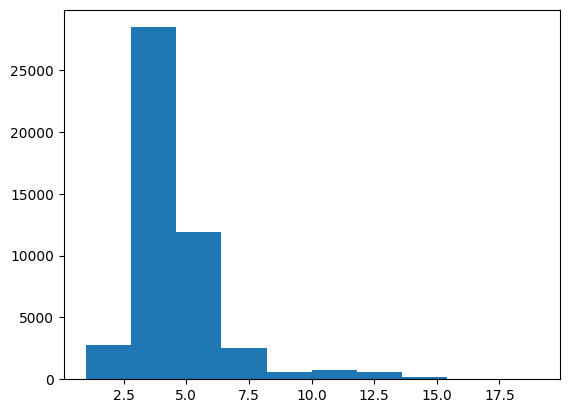

In [67]:
import matplotlib.pyplot as plt
# import seaborn as sns
print(len(frame))
# print the number of entries with length 5 or greater
print(len(frame.filter(pl.col('CODA').str.len_chars() >= 8)))
plt.hist(frame['CODA'].apply(len))
# print(frame['CODA'].apply(len))

In [9]:
from typing import Dict
import json
def get_merge_list(tokenizer_json_fname: str):
    with open(tokenizer_json_fname, 'r') as f:
        tokenizer_json = json.load(f)
        merges = tokenizer_json['model']['merges']
        return merges
    
def get_token_to_index_map(tokenizer_json_fname) -> Dict[str, int]:
    with open(tokenizer_json_fname, 'r') as f:
        tokenizer_json = json.load(f)
        vocab = tokenizer_json['model']['vocab']
        return {token: index for index, token in enumerate(vocab)}

    
tokenizer_json_fname = "hf_cache/models--bigscience--bloom-3b/snapshots/52bc5b43010b4844513826b8be3f78c7344c37d7/tokenizer.json"
merge_list = get_merge_list(tokenizer_json_fname)
vocab_to_index = get_token_to_index_map(tokenizer_json_fname)

In [10]:
def get_base_encoding(input_str: str): 
    input_bytes = input_str.encode("utf-8")
    input_strs = [whisper_tokenizer.byte_encoder[byte] for byte in input_bytes]
    input_tokens = [tokenizer.encode(s) for s in input_strs]
    print(input_tokens)
    # assert all(len(tokens) == 1 for tokens in input_tokens)
    # flatten the input tokens list and return it
    base_encoded_tokens = []
    for tokens in input_tokens:
        base_encoded_tokens.extend(tokens)
    return base_encoded_tokens

encoded = get_base_encoding("قدام")
decoded = tokenizer.decode(encoded)
decoded

[[101490], [130, 101], [97104], [196880], [97104], [6933], [101490], [130, 104]]


'ÙĤØ¯Ø§Ùħ'

In [12]:
from typing import Dict, List

def unwind_to_base_tokenization(input_str: str, vocab_token_to_index: Dict[str, int], vocab_merges: List[str],
                                tokenizer) -> List[int]: 
    """
    Params:
        input_str (str): String to get the base tokenization for.
        vocab_token_to_index (Dict[str, int]): Mapping from token to index in the vocabulary.
        vocab_merges (List[str]): List of merges in the vocabulary. Of the form "a b" where a and b are tokens.
        tokenizer: Huggingface tokenizer object.
    """
    encoding = tokenizer.encode(input_str) # List[int]
    # create an object token_to_source_merge. This will be a dictionary that maps a token (str) to the merge that created it (Tuple[str,str]).
    token_to_source_merge = {}
    for merge in vocab_merges:
        a, b = merge.split()
        token_to_source_merge[a + b] = (a, b)
    base_tokens = []

    def decompose(token: str) -> List[int]:
        if token in token_to_source_merge:
            a, b = token_to_source_merge[token]
            return decompose(a) + decompose(b) 
        else:
            # base token
            return [vocab_token_to_index[token]]

    base_tokens = []
    for token_ind in encoding:
        token = tokenizer.convert_ids_to_tokens([token_ind])[0]
        base_tokens.extend(decompose(token))
    return base_tokens

In [13]:
from typing import List, Set
def min_tokens_for_string(base_representation_s: List[str], vocabulary: Set[str]):
    n = len(base_representation_s)
    dp = [float('inf')] * (n + 1)
    dp[0] = 0  # Base case: empty string
    
    def _get_concatenation(slice: List[str]):
        return "".join(slice)

    for i in range(1, n + 1):
        for j in range(i):
            if _get_concatenation(base_representation_s[j:i]) in vocabulary:
                dp[i] = min(dp[i], dp[j] + 1)
    return dp[n]


#unwind_to_base_tokenization("hello", vocab_to_index, merge_list, tokenizer)
# token_inds = unwind_to_base_tokenization("قدام", vocab_to_index, merge_list, tokenizer)


In [14]:
def compute_min_tokenization(input_str):
    token_inds = unwind_to_base_tokenization(input_str, vocab_to_index, merge_list, tokenizer)
    tokens = tokenizer.convert_ids_to_tokens(token_inds)
    return min_tokens_for_string(tokens, bloom_vocab)

def compute_default_tokenization_length(input_str):
    return len(tokenizer.encode(input_str))


In [16]:
frame_sample = frame.sample(30)

ID,Concept_ID,Class,English,French,MSA,Dialect,Example,En_lemma_POS,Fr_lemma_POS,MSA_lemma_POS,CODA,Tokenization,CAPHI,Release Status,Release Note
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
15562,"""379""","""OpenClass""","""mistake""","""erreur""","""خَطَأ""","""ASW""",null,"""mistake_NOUN""","""erreur_NOUN""","""xaTaO_NOUN""","""زلة""","""زلة""","""z a l l a""","""READY""",null
43284,"""1230""","""OpenClass""","""right away""","""immédiatement""","""حالاً""","""AMM""",null,"""right_ADV away…","""immédiatement_…","""HAl_NOUN""","""رأسا""","""رأسا""","""r a 2 s a n""","""READY""",null
46090,"""1294""","""OpenClass""","""miss""","""mademoiselle""","""آنِسَة""","""ALX""",null,"""miss_PROPN""","""mademoiselle_P…","""Mnisap_NOUN""","""آنسة""","""آنسة""","""2 aa n i s a""","""CHECK""",null
355,"""12""","""OpenClass""","""insurance""","""assurance""","""تَأْمِين""","""ASW""",null,"""insurance_NOUN…","""assurance_NOUN…","""taOomiyn_NOUN""","""تأمين""","""تأمين""","""t a 2 m ii n""","""READY""",null
14642,"""359""","""OpenClass""","""bank""","""banque""","""بَنْك""","""ALX""",null,"""bank_NOUN""","""banque_NOUN""","""banok_NOUN""","""بنك""","""بنك""","""b a n k""","""CHECK""","""Foreign"""
8431,"""225""","""OpenClass""","""product""","""produit""","""مُنْتَج""","""DOH""",null,"""product_NOUN""","""produit_NOUN""","""munotaj_NOUN""","""انتاج""","""انتاج""","""2 e n t aa dj""","""READY""",null
20431,"""482""","""OpenClass""","""discount""","""remise""","""خَصْم""","""RIY""",null,"""discount_NOUN""","""remise_NOUN""","""xaSom_NOUN""","""خصم""","""خصم""","""kh a s. m""","""READY""",null
20092,"""474""","""OpenClass""","""house""","""maison""","""مَنْزِل""","""KHA""",null,"""house_NOUN""","""maison_NOUN""","""manozil_NOUN""","""بيت""","""بيت""","""b ee t""","""READY""",null
4850,"""145""","""OpenClass""","""breakfast""","""petit déjeuner…","""إِفْطار""","""SAL""",null,"""breakfast_NOUN…","""petit_ADJ déje…","""IifoTAr_NOUN""","""فطور""","""فطور""","""f a t. uu r""","""READY""",null


In [21]:
from functools import partial
from tqdm import tqdm

frame_sample = frame.sample(1000)
def compute_with_progress_bar(progress_bar, length_function, s):
    length = length_function(s)
    progress_bar.update(1)
    return length

progress = tqdm(total=len(frame_sample))
print(frame_sample['CODA'].apply(partial(compute_with_progress_bar, progress, compute_min_tokenization)))
# print(frame_sample['CODA'].apply(compute_default_tokenization_length).mean())

/var/folders/4s/lb1vnqls41q48r0glrfkkhnm0000gn/T/ipykernel_77723/3557112706.py:11: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  print(frame_sample['CODA'].apply(partial(compute_with_progress_bar, progress, compute_min_tokenization)))
